In [71]:
%autosave 0
%matplotlib inline

Autosave disabled


In [72]:
import sys
import os

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from thickshake.img.faces import enhance_image

In [73]:
TEST_INPUT_IMAGE = "/home/app/data/input/images/JPEG_Convert_Resolution_1024/slwa_b1921405_1_master.jpg"
TEST_OUTPUT_IMAGE = "/home/app/data/output/images/text/slwa_b1921405_1_master.jpg"
TRAINED_CLASSIFIER_DIR = "/home/app/src/lib/img/deps"

In [80]:
import tempfile

import cv2
import numpy as np
from PIL import Image

BINARY_THREHOLD = 130

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3


def remove_noise_and_smooth(file_name):
    img = cv2.imread(file_name, 0)
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 3)
    #filtered = img.copy()
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    #img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

In [81]:
#img      = cv.imread(TEST_INPUT_IMAGE)
#vis      = img.copy()

img = remove_noise_and_smooth(TEST_INPUT_IMAGE)
img = Image.fromarray(img) 
temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.jpg')
temp_filename = temp_file.name
img.save(temp_filename, dpi=(300, 300))
img = cv.imread(temp_filename)
vis      = img.copy()

In [82]:
# Extract channels to be processed individually
channels = cv.text.computeNMChannels(img)
# Append negative channels to detect ER- (bright regions over dark background)
cn = len(channels)-1
for c in range(0,cn):
    channels.append((255-channels[c]))

In [83]:
# Apply the default cascade classifier to each independent channel (could be done in parallel)
print("Extracting Class Specific Extremal Regions from "+str(len(channels))+" channels ...")
print("    (...) this may take a while (...)")

rects_array = []

for channel in channels:

    erc1 = cv.text.loadClassifierNM1(TRAINED_CLASSIFIER_DIR+'/trained_classifierNM1.xml')
    er1 = cv.text.createERFilterNM1(erc1,4,0.00015,0.15,0.2,True,0.1)

    erc2 = cv.text.loadClassifierNM2(TRAINED_CLASSIFIER_DIR+'/trained_classifierNM2.xml')
    er2 = cv.text.createERFilterNM2(erc2,0.5)

    regions = cv.text.detectRegions(channel,er1,er2)

    #rects = cv.text.erGrouping(img,channel,[r.tolist() for r in regions])
    rects = cv.text.erGrouping(img,channel,[x.tolist() for x in regions],
        cv.text.ERGROUPING_ORIENTATION_ANY,TRAINED_CLASSIFIER_DIR+"/trained_classifier_erGrouping.xml",0.5)

    rects_array.extend(rects)

    #Visualization
    for r in range(0,np.shape(rects)[0]):
        rect = rects[r]
        cv.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 2)

Extracting Class Specific Extremal Regions from 9 channels ...
    (...) this may take a while (...)


In [84]:
rects_array

[array([321, 626, 147,  45], dtype=int32),
 array([222, 146, 369,  38], dtype=int32),
 array([508, 244, 113, 459], dtype=int32),
 array([321, 626, 147,  45], dtype=int32),
 array([222, 146, 369,  38], dtype=int32),
 array([508, 244, 113, 459], dtype=int32),
 array([321, 626, 147,  45], dtype=int32),
 array([222, 146, 369,  38], dtype=int32),
 array([508, 244, 113, 459], dtype=int32),
 array([321, 626, 147,  45], dtype=int32),
 array([222, 146, 369,  38], dtype=int32),
 array([508, 244, 113, 459], dtype=int32),
 array([508, 221, 112, 481], dtype=int32)]

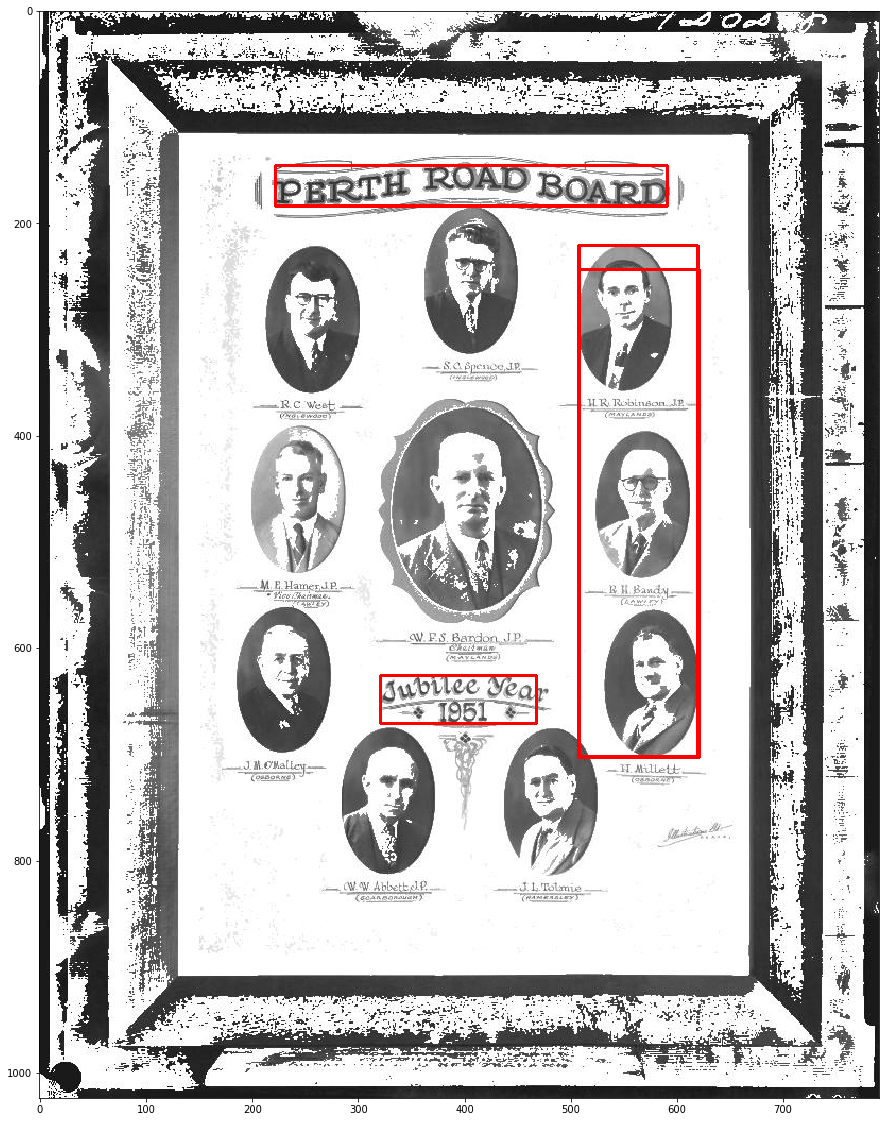

In [85]:
#Visualization
fig = plt.figure(figsize=(20,20))
plt.imshow(vis)
plt.show()
fig.savefig(TEST_OUTPUT_IMAGE, bbox_inches='tight')

In [88]:
from PIL import Image
import pytesseract
import cv2

In [89]:
print(pytesseract.image_to_data(Image.open(INPUT_TEST_IMAGE)))

AttributeError: module 'pytesseract' has no attribute 'image_to_data'